In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

[*********************100%***********************]  1 of 1 completed


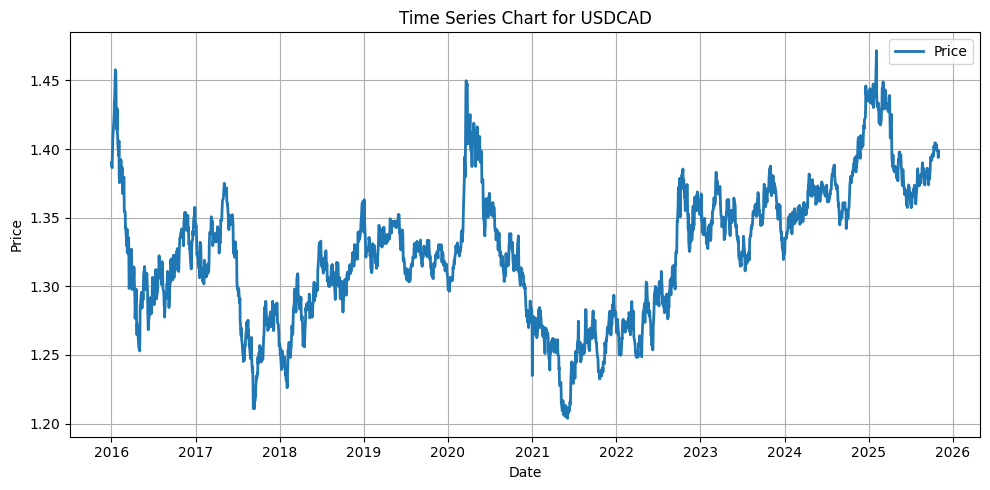

In [29]:
# Download historical USDCAD data from yfinance, choosing range that appears to mean revert
data = yf.download("CAD=X", start="2016-01-01", end="2025-11-01")
data = data["Close"].dropna()  # closing prices
data.to_csv("usdcad.csv")  # Save to CSV for reference
plt.figure(figsize=(10, 5))
plt.plot(data, label='Price', linewidth=2)
plt.title("Time Series Chart for USDCAD")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
data_t = data[:-1].values
data_t1 = data[1:].values
# OLS regression to estimate alpha, beta (ordinary least squares regression)
# Create design matrix for OLS: [1, data_t]
A = np.column_stack([np.ones_like(data_t), data_t])

# Solve least squares: minimize |A*[alpha,beta] - X_tp1|
alpha, beta = np.linalg.lstsq(A, data_t1, rcond=None)[0]


In [31]:
# Estimate OU parameters
data_freq = 1  # daily data, so Δt = 1 day
theta = -np.log(beta) / data_freq # Speed of mean reversion
mu = float(alpha / (1 - beta))  # Long-term mean, cast to scalar
resid = data_t1 - (alpha + beta * data_t)  # Residuals
resid_var = np.var(resid, ddof=1)  # Variance of residuals
# Discrete variance to continuous σ
sigma = float(np.sqrt(2 * theta * resid_var / (1 - np.exp(-2 * theta * data_freq))))  # Volatility, cast to scalar

# Simulation parameters
T = 10.0                # total time
dt = 0.01               # time step
N = int(T / dt)         # number of time steps
X_sim = np.zeros(N)     # pre-allocate array
X_sim[0] = mu           # start at estimated mean

In [32]:
# Generate OU process
np.random.seed(42)  # For reproducibility
for t in range(1, N):
    dW = np.sqrt(dt) * np.random.normal()
    X_sim[t] = X_sim[t-1] + theta * (mu - X_sim[t-1]) * dt + sigma * dW

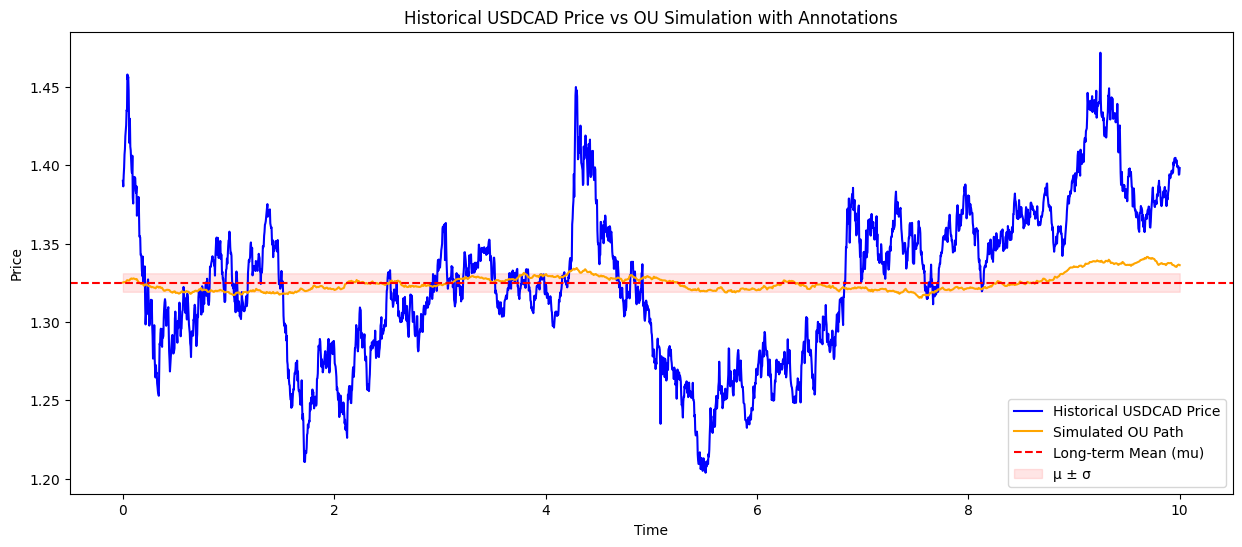

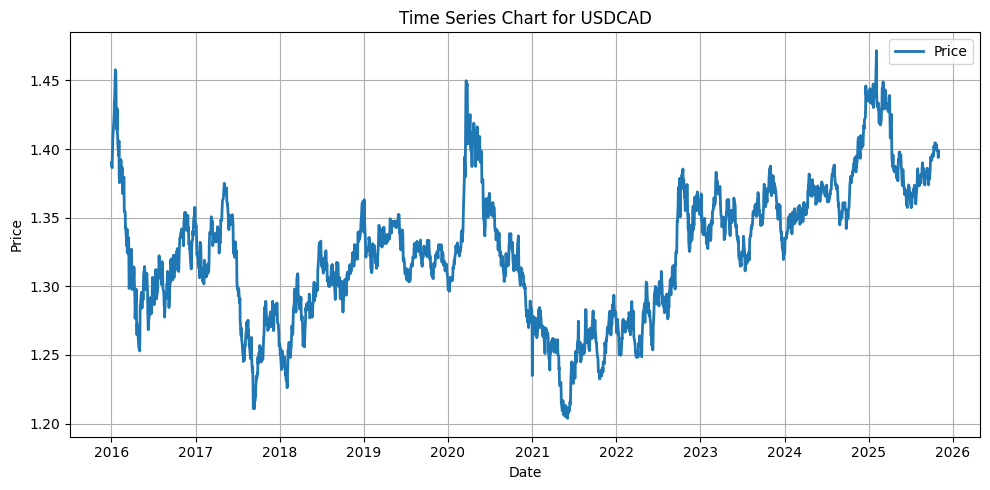

In [33]:
# Time axes
t_sim = np.linspace(0, T, N)       # simulation time
t_data = np.linspace(0, T, len(data))  # scale historical data to same T

# Plot historical data and OU simulation
plt.figure(figsize=(15,6))
plt.plot(t_data, data, label="Historical USDCAD Price", color="blue")
plt.plot(t_sim, X_sim, label="Simulated OU Path", color="orange")

# Long-term mean line
plt.axhline(mu, color="red", linestyle="--", label="Long-term Mean (mu)")

# Optional: shaded area μ ± σ
plt.fill_between(t_sim, mu - sigma, mu + sigma, color='red', alpha=0.1, label='μ ± σ')

# Annotate μ
#plt.text(T*0.8, mu + 1, f"μ = {mu:.2f}", color='red')

# Annotate σ range
#plt.text(T*0.8, mu + sigma + 0.5, f"σ = {sigma:.2f}", color='red')

# Annotate example mean-reversion
#example_t = int(N*0.3)  # pick a point in the simulation
#plt.annotate("Mean reversion",
#             xy=(t_sim[example_t], X_sim[example_t]),
#             xytext=(t_sim[example_t]+0.5, X_sim[example_t]+5),
#             arrowprops=dict(facecolor='black', arrowstyle="->"))

# Labels and title
plt.title("Historical USDCAD Price vs OU Simulation with Annotations")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data, label='Price', linewidth=2)
plt.title("Time Series Chart for USDCAD")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
print('mean:', mu)
print('standard deviation:', sigma)
print('theta:', theta[0])
print('vol:', sigma*15.9)

mean: 1.3251151062508881
standard deviation: 0.005904178149517366
theta: 0.0070791671411026234
vol: 0.09387643257732611
